In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 하루

In [2]:
df = pd.read_csv(
    "../input/10min/ontune2016.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52008, 2)


,date,value
0,2020-03-28 09:00:00,16
1,2020-03-28 09:10:00,9
2,2020-03-28 09:20:00,9
3,2020-03-28 09:30:00,9
4,2020-03-28 09:40:00,9


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df.tail()

,ds,y
52003,2021-03-26 08:10:00,12
52004,2021-03-26 08:20:00,12
52005,2021-03-26 08:30:00,12
52006,2021-03-26 08:40:00,13
52007,2021-03-26 08:50:00,12


In [4]:
train = df[df['ds'] < '2021-03-01']
valid = df.copy()
valid["days"] = valid["ds"].apply(lambda x: x.day)
valid = valid.groupby("days")["y"].agg("mean")

In [7]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [50, 100, 200, 300, 400, 500]),
        "batch_size": 64,
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 0, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)

    return val_rmse

In [8]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

[I 2021-05-12 14:23:24,207] A new study created in memory with name: no-name-af8d9b3b-1b4c-4f80-b720-c163be5a9973
Epoch[100/100]: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it, MSELoss=0.194, MAE=5.06, RegLoss=0]
[I 2021-05-12 14:25:07,301] Trial 0 finished with value: 10.384591700230285 and parameters: {'epochs': 100, 'num_hidden_layers': 0, 'learning_rate': 0.08675143843171859, 'changepoints_range': 0.89, 'n_changepoints': 31}. Best is trial 0 with value: 10.384591700230285.
Epoch[100/100]: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s, MSELoss=0.208, MAE=5.21, RegLoss=0]
[I 2021-05-12 14:26:46,639] Trial 1 finished with value: 3.7854655795611563 and parameters: {'epochs': 100, 'num_hidden_layers': 1, 'learning_rate': 0.05295088673159155, 'changepoints_range': 0.865, 'n_changepoints': 24}. Best is trial 1 with value: 3.7854655795611563.
Epoch[500/500]: 100%|██████████| 500/500 [08:12<00:00,  1.02it/s, MSELoss=0.206, MAE=5.26, RegLoss=0]
[I 2021-05-12 14:34:59,484] Trial 2 finis

Epoch[500/500]: 100%|██████████| 500/500 [07:59<00:00,  1.04it/s, MSELoss=0.175, MAE=4.9, RegLoss=0] 
[I 2021-05-12 15:42:12,315] Trial 17 finished with value: 23.065337501280432 and parameters: {'epochs': 500, 'num_hidden_layers': 4, 'learning_rate': 0.03793362609091168, 'changepoints_range': 0.915, 'n_changepoints': 34}. Best is trial 14 with value: 3.6471668796958396.
Epoch[300/300]: 100%|██████████| 300/300 [04:52<00:00,  1.03it/s, MSELoss=0.205, MAE=5.18, RegLoss=0]
[I 2021-05-12 15:47:04,964] Trial 18 finished with value: 4.667902637962093 and parameters: {'epochs': 300, 'num_hidden_layers': 3, 'learning_rate': 0.017445010590136197, 'changepoints_range': 0.8680000000000001, 'n_changepoints': 29}. Best is trial 14 with value: 3.6471668796958396.
Epoch[300/300]: 100%|██████████| 300/300 [04:51<00:00,  1.03it/s, MSELoss=0.209, MAE=5.19, RegLoss=0]
[I 2021-05-12 15:51:57,058] Trial 19 finished with value: 3.624813802215533 and parameters: {'epochs': 300, 'num_hidden_layers': 5, 'lear

In [9]:
prophet_params = study.best_params
prophet_params["batch_size"] = 64
prophet_params["seasonality_mode"] = "additive"
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [10]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(train, freq="1D")
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[300/300]: 100%|██████████| 300/300 [04:50<00:00,  1.03it/s, MSELoss=0.209, MAE=5.19, RegLoss=0]


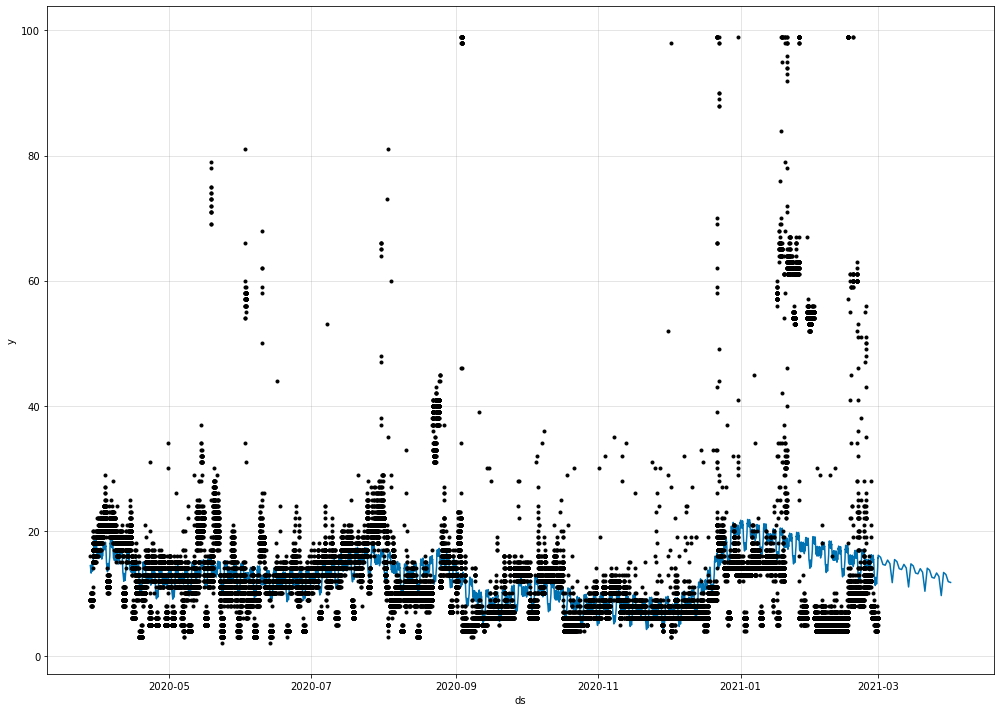

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

In [12]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1D")
future = model.make_future_dataframe(df, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[300/300]: 100%|██████████| 300/300 [05:15<00:00,  1.05s/it, MSELoss=0.18, MAE=4.95, RegLoss=0] 


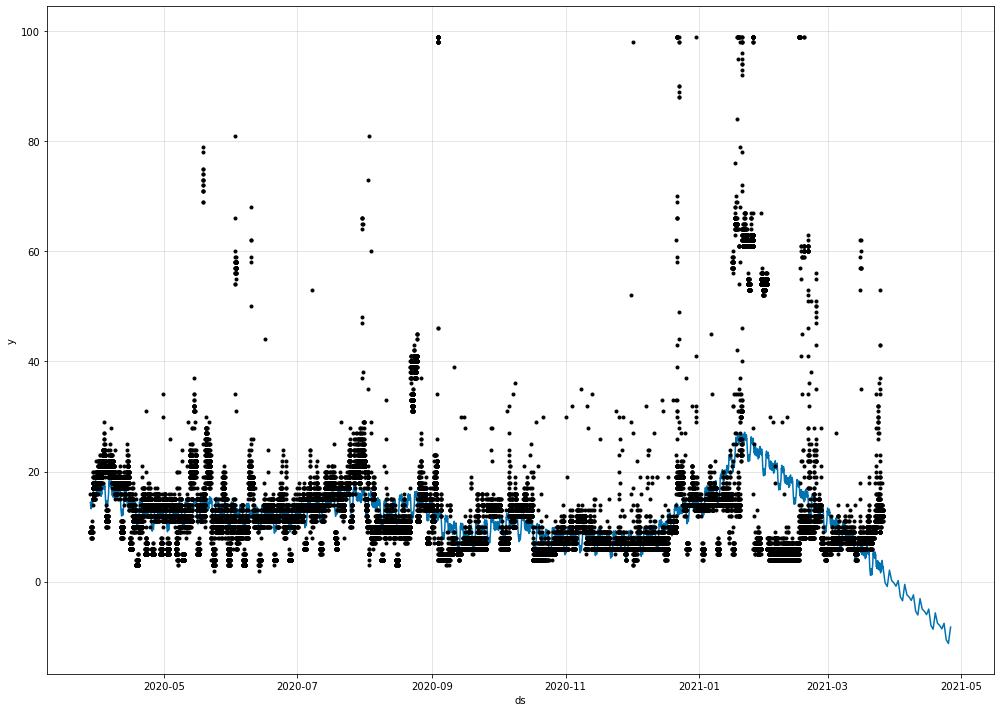

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()